# Metody Inteligencji Obliczeniowej w Analizie Danych

## 2.2 Wypełnianie koła prostokątami

Rozwiązać wariant problemu znanego w literaturze jako cutting stock problem.

Mamy dane koło o promieniu r oraz zbiór dostępnych prostokątów zadanych przez trzy liczby: wysokość, szerokość i wartość.

Celem jest ułożenie prostokątów w kole tak, aby zmaksymalizować sumę ich wartości, spełniając następujące warunki:

* boki wszystkich prostokątów były równoległe do osi układu
* wnętrza prostokątów nie miały części wspólnej (intuicyjnie: prostokąty nie nachodzą na siebie, ale mogą się stykać bokami)
* każdy prostokąt można wstawić dowolnie wiele razy

Zaproponować kodowanie problemu, operator mutacji i krzyżowania i zaimplementować algorytm genetyczny rozwiązujący powyższy problem.

Przetestować rozwiązanie na danych dostarczonych w pliku http://pages.mini.pw.edu.pl/~karwowskij/mioad/cutting.tar.xz.

Struktura pliku: w nazwie pliku jest podany promień koła, plik jest w formacie csv: pierwsza kolumna to szerokość prostokąta, druga to wysokość, trzecia to wartość prostokąta.


In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt

### Implementacja

In [2]:
# funkcja celu
class Objective:
    @staticmethod
    def calculate(rect_set):
        score = 0 
        for i in range(rect_set.shape[0]):
            score += rect_set[i,1]
        return score
class Rectangle:
    def __init__(self, bottom_left_x, bottom_left_y, width, height):
        self.width = width
        self.height = height
        self.bottom_left_x = bottom_left_x
        self.bottom_left_y = bottom_left_y
        
def vis_grid(r, n=100):
    x =  [math.sin(2*math.pi/n*x)*r for x in range(0,n+1)]
    y = [math.cos(2*math.pi/n*x)*r for x in range(0,n+1)]
    return x,y

In [3]:
class CuttingStock:
    
    def __init__(self, r, path_to_file, pop_size):
        self.r = r
        self.pop_size = pop_size
        data = pd.read_csv(path_to_file, header = None)
        data.columns = ['width', 'height', 'value']
        self.data = data
        
    def do_overlap(self, rect_1, rect_2):
        if rect_1.bottom_left_x >= rect_2.bottom_left_x + rect_2.width:
            return False
        elif rect_1.bottom_left_x + rect_1.width <= rect_2.bottom_left_x:
            return False
        elif rect_1.bottom_left_y + rect_1.height <= rect_2.bottom_left_y:
            return False
        elif rect_1.bottom_left_y >= rect_2.bottom_left_y + rect_2.height:
            return False
        else: 
            return True 
            
    def check_constraints(self, rect_set):
        
        for i in range(rect_set.shape[0]):
            rect = rect_set[i, 0]
            
            for x, y in zip([rect.bottom_left_x, rect.bottom_left_x+rect.width, rect.bottom_left_x, rect.bottom_left_x+rect.width],\
                             [rect.bottom_left_y, rect.bottom_left_y, rect.bottom_left_y+rect.height, rect.bottom_left_y+rect.height]):
                
                if math.sqrt(x**2 + y**2) > self.r:
                    return False 
                
            for j in range(rect_set.shape[0]):
                if i == j: continue
                other = rect_set[j, 0]
                if self.do_overlap(rect, other):
                    return False
        return True
    
    def generate_random_rectangle(self):
        
        while True: 
            bottom_left = np.random.uniform(-self.r, self.r, 2)
            valid_coord = True
            
            index = random.randint(0, self.data.shape[0]-1)
            width = self.data.iloc[index,0]
            height = self.data.iloc[index,1]
            
            # obrót 
            if random.randint(0, 1) == 1: width, height = height, width

            for x, y in zip([bottom_left[0], bottom_left[0]+width, bottom_left[0]+width, bottom_left[0]],
                            [bottom_left[1], bottom_left[1], bottom_left[1]+height, bottom_left[1]+height]):
                
                if math.sqrt(x**2 + y**2) > self.r: 
                    valid_coord = False
                    break
                    
            if valid_coord:
                rect_object = Rectangle(bottom_left[0], bottom_left[1], width, height)
                value = self.data.iloc[index,2]
                return [rect_object, value] 

    def generate_population(self):
        self.population = [0] * self.pop_size
        
        for i in range(len(self.population)):
            random_rects = self.generate_random_rectangle()
            random_rects = np.array([random_rects])

            count = 1
            while count < 200: 
                new_random_rects = self.generate_random_rectangle()
                if not self.check_constraints(np.vstack([random_rects, new_random_rects])):
                    count += 1
                    continue
                random_rects = np.vstack([random_rects, new_random_rects])
            
            self.population[i] = random_rects[:-1]
            
    # optymalizacja        
    def evaluate(self, cross_prob=0.8, mutation_prob=0.2, mutation_rate=0.5, n_epochs=500):

        for generation in range(n_epochs):

            parents_idxs = np.random.randint(0, len(self.population), size=2)
            
            child1, child2 = self.population[parents_idxs[0]].copy(), self.population[parents_idxs[0]].copy()
            
            # krzyżowanie
            if random.uniform(0, 1) <= cross_prob:
                child1 = np.vstack([self.population[parents_idxs[0]][0:(len(self.population[parents_idxs[0]])//2),:],
                                   self.population[parents_idxs[1]][(len(self.population[parents_idxs[1]])//2):,:]])
                
                child2 = np.vstack([self.population[parents_idxs[1]][0:(len(self.population[parents_idxs[1]])//2),:],
                                   self.population[parents_idxs[0]][(len(self.population[parents_idxs[0]])//2):,:]])
                
                children = [child1, child2]
                
                for i in range(len(children)):
                    child = children[i]
                    
                    # mutacja
                    if random.uniform(0, 1) <= mutation_prob:
                        nr_of_rects = max([math.floor(child.shape[0]*mutation_rate),1])
                        rects_in_child_idxs = np.random.choice(child.shape[0], replace=False, size=nr_of_rects)

                        for j in range(nr_of_rects):                            
                            random_rectangle = self.generate_random_rectangle()
                            child[rects_in_child_idxs[j]] = random_rectangle

                        if self.check_constraints(child): 
                            self.population[parents_idxs[i]] = child

                            
            # selekcja
            individual_scores = [0]*len(self.population)
            
            for ind_idx in range(len(self.population)):
                individual_scores[ind_idx] = self.calculate(self.population[ind_idx])
                
            scores_total = np.sum(individual_scores)
            ind_probabilities = (individual_scores/scores_total).astype('float64')
            
            idxs_arr = np.array(range(0, len(self.population), 1))
            chosen_idxs = np.random.choice(a = idxs_arr, size = self.pop_size, p = ind_probabilities, replace=False)
            self.population = [self.population[i] for i in chosen_idxs]
            
            # znajdowanie najlepszego rozwiazania
            scores = [0]*len(self.population)

            for i in range(len(self.population)):
                rect_objects = self.population[i]
                scores[i] = self.calculate(rect_objects)

        return self.population[np.argmax(scores)], np.max(scores)
    
    @staticmethod
    def calculate(rect_set):
        score = 0 
        for i in range(rect_set.shape[0]):
            score += rect_set[i,1]
        return score

### Testowanie rozwiązania

In [4]:
r800 = '../data/mio3/cutting/r800.csv'
r850 = '../data/mio3/cutting/r850.csv'
r1000 = '../data/mio3/cutting/r1000.csv'
r1100 = '../data/mio3/cutting/r1100.csv'
r1200 = '../data/mio3/cutting/r1200.csv'

In [5]:
sets = [r800, r850, r1000, r1100, r1200]
r_arr = [800, 850, 1000, 1100, 1200]

Best result:  7860


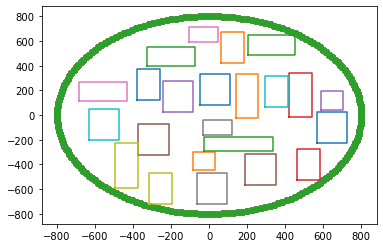

Best result:  9020


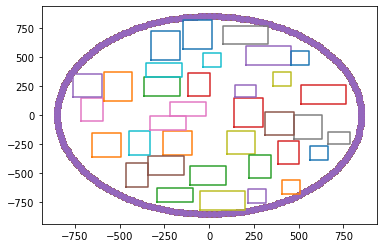

Best result:  162290


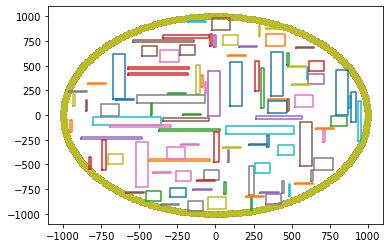

Best result:  17140


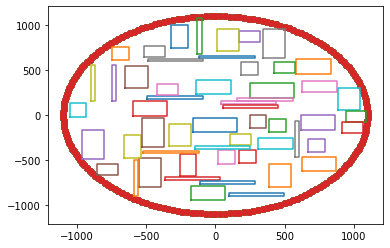

Best result:  16580


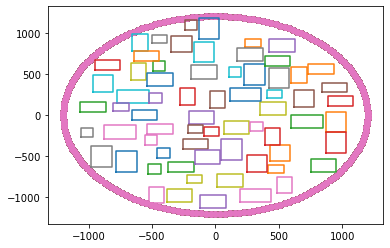

In [6]:
# populacja 500
for data, r in zip(sets, r_arr):
    cs_object = CuttingStock(r = r, path_to_file = data, pop_size=500)
    cs_object.generate_population()
    best_ind, best_res = cs_object.evaluate(n_epochs = 1000)
    print('Best result: ', best_res)    
    Ox,Oy = vis_grid(r, n=200)
    for rect in range(best_ind.shape[0]):
        rect_object = best_ind[rect][0]
        x = rect_object.bottom_left_x
        y = rect_object.bottom_left_y
        width = rect_object.width
        height = rect_object.height
        plt.scatter(Ox,Oy)
        plt.plot([x, x+width,x+width,x,x],[y,y,y+height,y+height,y])
    plt.show()

R:  800  Best result:  8700


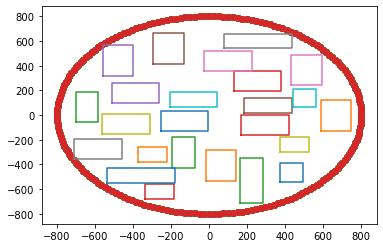

R:  850  Best result:  9500


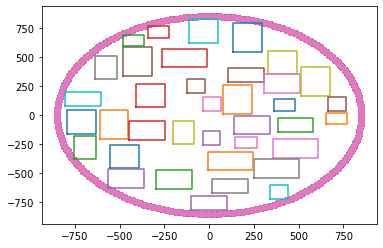

R:  1000  Best result:  155150


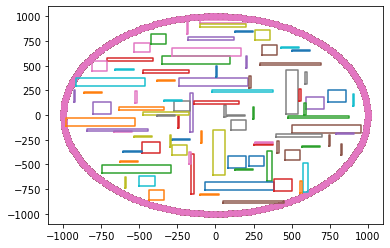

R:  1100  Best result:  17780


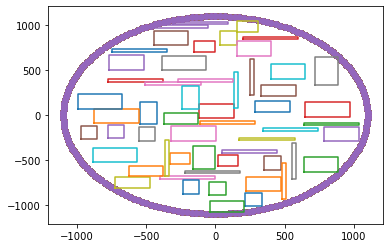

R:  1200  Best result:  16700


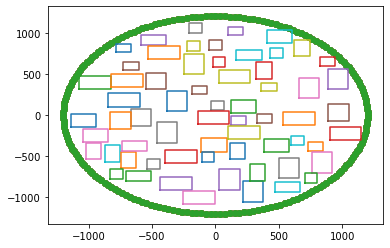

In [7]:
# populacja 1000
for data, r in zip(sets, r_arr):
    cs_object = CuttingStock(r = r, path_to_file = data, pop_size=1000)
    cs_object.generate_population()
    best_ind, best_res = cs_object.evaluate(n_epochs = 1000)
    print('R: ', r, ' Best result: ', best_res)    
    Ox,Oy = vis_grid(r, n=200)
    for rect in range(best_ind.shape[0]):
        rect_object = best_ind[rect][0]
        x = rect_object.bottom_left_x
        y = rect_object.bottom_left_y
        width = rect_object.width
        height = rect_object.height
        plt.scatter(Ox,Oy)
        plt.plot([x, x+width,x+width,x,x],[y,y,y+height,y+height,y])
    plt.show()